In [ ]:
from fastai.text.all import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline, AutoModel, AutoModelForTokenClassification
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split,StratifiedKFold, cross_validate
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import re, nltk, string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from collections import defaultdict

In [ ]:
from tqdm import tqdm
import transformers
from transformers import AutoTokenizer
from transformers import  DistilBertForTokenClassification
from torch.optim import AdamW
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [160]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
labeled_df = pd.read_csv('https://raw.githubusercontent.com/jforster19/Data698/main/train_set.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/jforster19/Data698/main/Test_set.csv')

In [ ]:
labeled_df.shape, test_df.shape

((10215, 4), (2588, 4))

#### Validation of Consistent Labels

In [ ]:
labeled_df['Row'] = labeled_df.index
test_df['Row'] = test_df.index

In [ ]:
labeled_df.loc[:,'ent_semi_cnt'] = labeled_df.apply(lambda x: 0 if pd.isna(x['Entity']) else len(re.sub('[^;]','',x['Entity'])), axis=1)
labeled_df.loc[:,'class_semi_cnt'] = labeled_df.apply(lambda x: 0 if pd.isna(x['Class']) else len(re.sub('[^;]','',x['Class'])), axis=1)
labeled_df.loc[:,'semi_diff'] = labeled_df.apply(lambda x: x['ent_semi_cnt']-x['class_semi_cnt'],axis=1)
test_df.loc[:,'ent_semi_cnt'] = test_df.apply(lambda x: 0 if pd.isna(x['Entity']) else len(re.sub('[^;]','',x['Entity'])), axis=1)
test_df.loc[:,'class_semi_cnt'] = test_df.apply(lambda x: 0 if pd.isna(x['Class']) else len(re.sub('[^;]','',x['Class'])), axis=1)
test_df.loc[:,'semi_diff'] = test_df.apply(lambda x: x['ent_semi_cnt']-x['class_semi_cnt'],axis=1)
#labeled_df[(~pd.isna(labeled_df['Class'])) & (pd.isna(labeled_df['Entity']))]

In [ ]:
labeled_df[labeled_df['semi_diff']!=0]

Empty DataFrame
Columns: [Unnamed: 0, Comments, Entity, Class, Row, ent_semi_cnt, class_semi_cnt, semi_diff]
Index: []

In [ ]:
test_df[test_df['semi_diff']!=0]

Empty DataFrame
Columns: [Unnamed: 0, Comments, Entity, Class, Row, ent_semi_cnt, class_semi_cnt, semi_diff]
Index: []

In [ ]:
print(labeled_df.columns)
labeled_df.head()

Index(['Row', 'Comments', 'Entity', 'Class', 'Cutoff', 'ent_semi_cnt',
       'class_semi_cnt', 'semi_diff'],
      dtype='object')


Row  \
0    0   
1    1   
2    2   
3    3   
4    4   

                                                                    Comments  \
0        Can’t believe I have a reason to watch Selection Sunday.  Go Pack!!   
1  How am I supposed to keep track of tournament games without bar graphs???   
2               Can’t wait to complain about refs with all of you. War Eagle   
3                 After the craziness yesterday... I am super nervous now...   
4                                    The no-flair horde will soon be upon us   

  Entity Class Cutoff  ent_semi_cnt  class_semi_cnt  semi_diff  
0   Pack  Team    NaN             0               0          0  
1    NaN   NaN    NaN             0               0          0  
2    NaN   NaN    NaN             0               0          0  
3    NaN   NaN    NaN             0               0          0  
4    NaN   NaN    NaN             0               0          0

In [ ]:
new_cols = labeled_df['Entity'].str.split(';',expand=True)
new_cols.loc[:,'row'] = new_cols.index
new_class = labeled_df['Class'].str.split(';',expand=True)
new_class.loc[:,'row'] = new_class.index

In [ ]:
tmp_new = new_cols.melt(id_vars='row',value_name='entity')
tmp_new.loc[:,'row_order'] = tmp_new.groupby(['row']).cumcount()
tmp_class = new_class.melt(id_vars='row',value_name='class')
tmp_class.loc[:,'row_order'] = tmp_class.groupby(['row']).cumcount()

In [ ]:
pivot_labels = pd.merge(tmp_new,tmp_class,how='inner',on=['row','row_order']).sort_values(by=['row','row_order'])

#### Confirming Join worked as expected

In [ ]:
print(pivot_labels.shape,tmp_new.shape,tmp_class.shape)

(347310, 6) (347310, 4) (347310, 4)


In [ ]:
test_new_cols = test_df['Entity'].str.split(';',expand=True)
test_new_cols.loc[:,'row'] = test_new_cols.index
test_new_class = test_df['Class'].str.split(';',expand=True)
test_new_class.loc[:,'row'] = test_new_class.index
test_tmp_new = test_new_cols.melt(id_vars='row',value_name='entity')
test_tmp_new.loc[:,'row_order'] = test_tmp_new.groupby(['row']).cumcount()
test_tmp_class = test_new_class.melt(id_vars='row',value_name='class')
test_tmp_class.loc[:,'row_order'] = test_tmp_class.groupby(['row']).cumcount()
pivot_test = pd.merge(test_tmp_new,test_tmp_class,how='inner',on=['row','row_order']).sort_values(by=['row','row_order'])

In [ ]:
print(pivot_test.shape,test_tmp_new.shape,test_tmp_class.shape)

(54348, 6) (54348, 4) (54348, 4)


### Cleaning up labeling varieties

In [ ]:
pivot_labels.groupby('class')['row'].count()

class
  Team             6
 Coach          1174
 Conference      305
 Conference       11
 Palyer            1
 Player          981
 Player           12
 TEam              1
 Team           2965
 Tearm             1
 team              7
Caoch              1
Coach           1348
Coahc              1
Conference       271
Conference         8
Player           679
Player            12
Team            2766
coach              1
conference         1
team               1
Name: row, dtype: int64

In [ ]:
pivot_test.groupby('class')['row'].count()

class
  Team           1
 Coach         279
 Conference     71
 PLayer          1
 Player        238
 Teaam           1
 Team          776
 team            9
Coach          333
Conference      48
Player         116
Team           900
coach            1
team             2
Name: row, dtype: int64

Correcting for Labeling Inconsistencies

In [ ]:
pivot_labels['class'] = pivot_labels['class'].apply(lambda x: None if pd.isna(x) else
                                          'Team' if re.match('tea.*',x.strip().lower()) else
                                          'Conference' if re.match('conf.*',x.strip().lower()) else
                                          'Player' if re.match('p.*',x.strip().lower()) else 'Coach')
pivot_labels['entity'] = pivot_labels['entity'].apply(lambda x: None if pd.isna(x) else x.strip())
pivot_test['class'] = pivot_test['class'].apply(lambda x: None if pd.isna(x) else
                                          'Team' if re.match('tea.*',x.strip().lower()) else
                                          'Conference' if re.match('conf.*',x.strip().lower()) else
                                          'Player' if re.match('p.*',x.strip().lower()) else 'Coach')
pivot_test['entity'] = pivot_test['entity'].apply(lambda x: None if pd.isna(x) else x.strip())

In [ ]:
pivot_labels[~pd.isna(pivot_labels['entity'])]   #.head()

row variable_x      entity  row_order variable_y  class
0          0          0        Pack          0          0   Team
11        11          0         UNC          0          0   Team
12        12          0         UNC          0          0   Team
10227     12          1  Iowa State          1          1   Team
16        16          0    Peacocks          0          0   Team
...      ...        ...         ...        ...        ...    ...
30635  17983          2         Jim          2          2  Coach
10206  17984          0       UConn          0          0   Team
10207  17985          0       UConn          0          0   Team
10211  17989          0     Jayhawk          0          0   Team
10212  17990          0         Cal          0          0  Coach

[10553 rows x 6 columns]

In [ ]:
pivot_test[~pd.isna(pivot_test['entity'])].head()

row variable_x      entity  row_order variable_y       class
0        0          0  Louisville          0          0        Team
2588     0          1    Big East          1          1  Conference
5176     0          2         ACC          2          2  Conference
7764     0          3         B12          3          3  Conference
10352    0          4         SEC          4          4  Conference

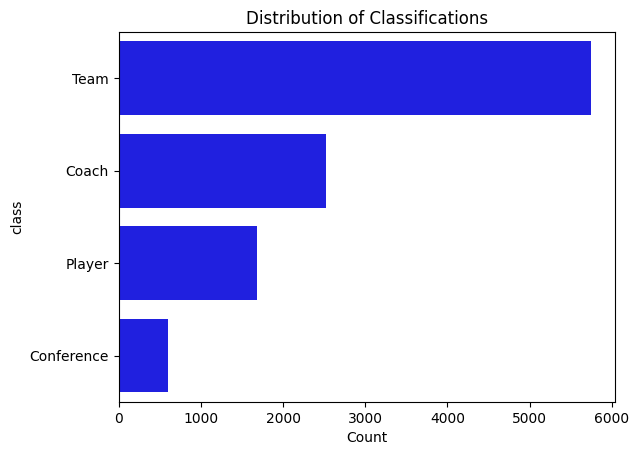

In [ ]:
sns.barplot(data=pivot_labels.groupby('class')['row'].count().rename('Count').reset_index().sort_values(by=['Count'],ascending=False),
            y='class',x='Count',color='Blue')
plt.title('Distribution of Classifications')
plt.show();

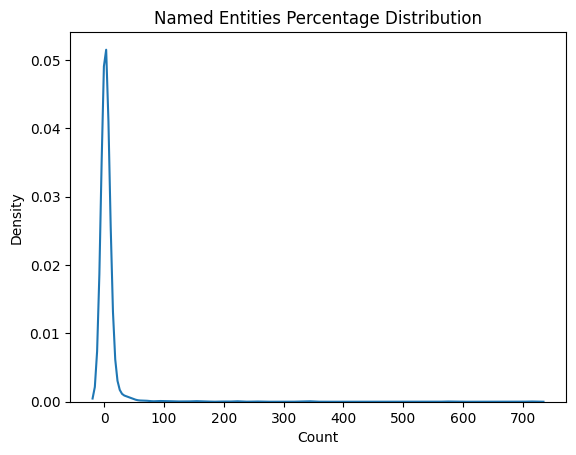

In [ ]:
sns.kdeplot(data=pivot_labels.groupby('entity')['row'].count().sort_values(ascending=False).rename('cnt'))
plt.title('Named Entities Percentage Distribution')
plt.xlabel('Count')
plt.show();

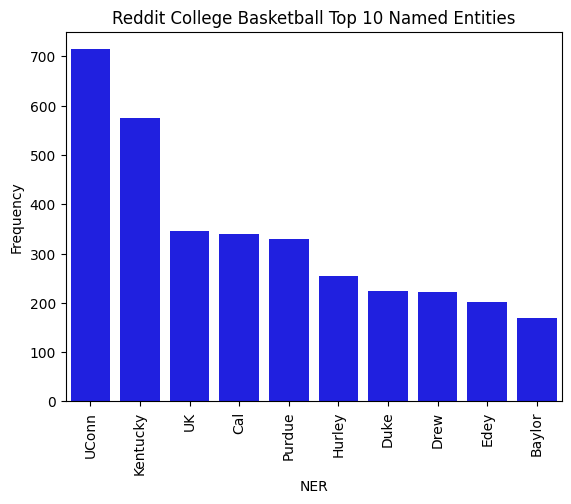

In [ ]:
sns.barplot(data=pivot_labels.groupby('entity')['row'].count().sort_values(ascending=False).rename('cnt').reset_index()[:10],x='entity',y='cnt',
           color='blue')
plt.title('Reddit College Basketball Top 10 Named Entities')
plt.xticks(rotation=90)
plt.xlabel('NER')
plt.ylabel('Frequency')
plt.show();

The top terms that existed in the annotated Reddit threads are shown above. All of the entities are related to teams that were involved at the NCAA tournament or were related to coaching changes in the offseason.

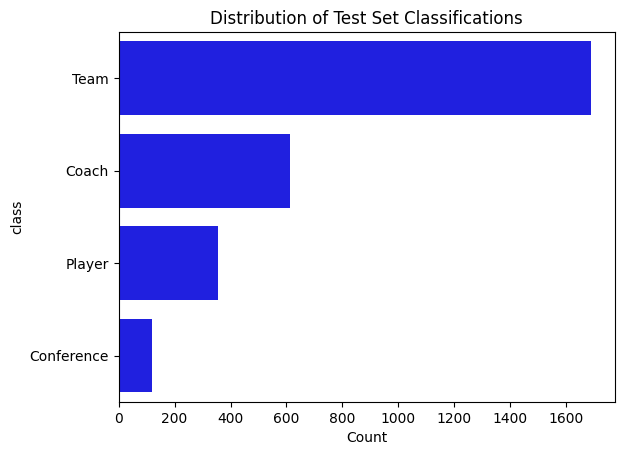

In [ ]:
sns.barplot(data=pivot_test.groupby('class')['row'].count().rename('Count').reset_index().sort_values(by=['Count'],ascending=False),
            y='class',x='Count',color='Blue')
plt.title('Distribution of Test Set Classifications')
plt.show();

The splits between the training and test set are consistent and exhibit similar imbalances.

In [ ]:
pivot_labels.columns
cln_data = pivot_labels[~pd.isna(pivot_labels['entity'])]
prep_df = labeled_df.merge(cln_data,how='inner',left_on='Row',right_on ='row')[['Row','Comments','entity','class']]
prep_df.shape

(10553, 4)

In [ ]:
test_data = pivot_test[~pd.isna(pivot_test['entity'])]
prep_test = test_df.merge(test_data,how='inner',left_on='Row',right_on ='row')[['Row','Comments','entity','class']]
prep_test.shape

(2776, 4)

#### ULMFit Fine Tuning

In [ ]:
dls = TextDataLoaders.from_df(df=prep_df,valid_pct=0.2,seed=12,text_col='Comments',label_col='class')
dls.show_batch(max_n=3)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


### Preparing Learner for Fine Tuning

In [ ]:
learn1 = text_classifier_learner(dls,AWD_LSTM, drop_mult=0.5,metrics=accuracy)

In [ ]:
learn1.fine_tune(epochs=4,base_lr=1e-2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

In [ ]:
learn1.unfreeze()
learn1.fit_one_cycle(10, 1e-3)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

In [ ]:
learn1.save_encoder('finetuned')

In [ ]:
learn1 = learn1.load_encoder('finetuned')

In [ ]:
learn1.fit_one_cycle(1, 2e-2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


#### Unfreeze layers within the NN

In [ ]:
learn1.freeze_to(-2)
learn1.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
learn1.freeze_to(-2)
learn1.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
learn1.unfreeze()
learn1.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
learn1.save('lm1')

Path('models/lm1.pth')

In [ ]:
text_interp = ClassificationInterpretation.from_learner(learn1)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


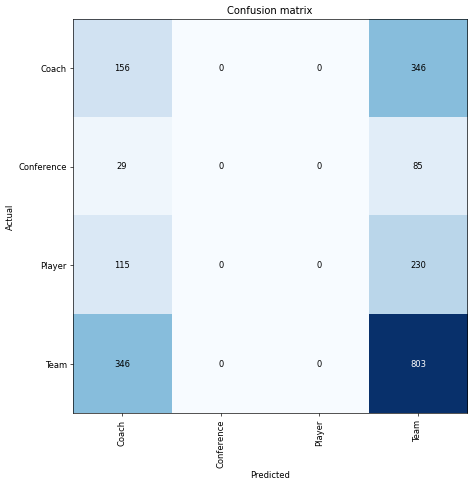

In [ ]:
text_interp.plot_confusion_matrix(figsize=(8,8),dpi=60)

In [ ]:
text_interp.plot_top_losses(5,figsize=(8,8))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
text_interp.most_confused(min_val=2)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[('Coach', 'Team', 346),
 ('Team', 'Coach', 346),
 ('Player', 'Team', 230),
 ('Player', 'Coach', 115),
 ('Conference', 'Team', 85),
 ('Conference', 'Coach', 29)]

#### Evaluating the Confusion Matrix:
The confusion matrix can be a very helpful way to identify potential areas for improvement within the model. The diagonal line identifies the correct classifications which based on the results considerably inaccurate for two of the labeled categories. Part of the challenge with the dataset that is used is that many Reddit comments reference multiple classes.

In [ ]:
prep_test_label = prep_test['Comments'].apply(lambda x: learn1.predict(x))

In [ ]:
prep_test['ulmfit_pred'] = prep_test_label.apply(lambda x: x[0])

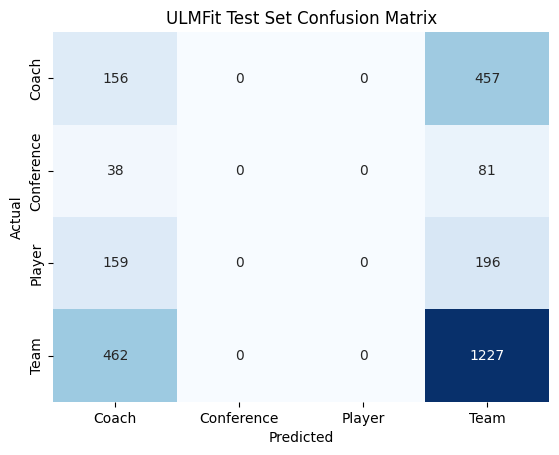

In [ ]:
ulm_test_cm = metrics.confusion_matrix(prep_test['class'],prep_test['ulmfit_pred'])
ulm_cm_df = pd.DataFrame(ulm_test_cm,index=['Coach','Conference','Player','Team'],columns=['Coach','Conference','Player','Team'])
sns.heatmap(ulm_cm_df,fmt='g',cmap='Blues',annot=True,cbar=False)
plt.title('ULMFit Test Set Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

### Testing fake examples against model

In [ ]:
learn1.predict('this new guy pope better still get the same recruits for our team')

('Coach', tensor(0), tensor([9.1226e-01, 6.7505e-05, 8.1886e-02, 5.7839e-03]))

In [ ]:

learn1.predict('with the annoucement and changes in the program this should mean a top 3 Place in the ivy')

('Team', tensor(3), tensor([0.0281, 0.0429, 0.0690, 0.8600]))

In [ ]:
learn1.predict('sad to see lampkin go. the transfer portal is rough')

('Player', tensor(2), tensor([0.0076, 0.0672, 0.8484, 0.0768]))

#### Evaluating the DistilBert Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline, AutoModel, AutoModelForTokenClassification
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split,StratifiedKFold
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [126]:
mod_dis = 'distilbert-base-uncased'
tokenizer_disbert = AutoTokenizer.from_pretrained(mod_dis)
MAX_LEN = 512
TR_BATCH_SIZE = 4
VAL_BATCH_SIZE = 1
BATCH_SIZE = 50
epochs = 1
LEARNING_RATE = 1e-05

In [ ]:
prep_class_df = prep_df.copy()
prep_class_df.rename(columns={'class':'labels_str'},inplace=True)
label_num = {'Conference':0,'Player':1,'Coach':2,'Team':3}
prep_class_df['labels'] = prep_class_df['labels_str'].apply(lambda x: label_num[x])
prep_class_df.columns

Index(['Row', 'Comments', 'entity', 'labels_str', 'labels'], dtype='object')

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=5)
sss.get_n_splits(prep_class_df['Comments'],prep_class_df['labels'])
for (tr_idx,te_idx) in sss.split(prep_class_df['Comments'],prep_class_df['labels']):
    train_class_idx = tr_idx
    val_class_idx = te_idx


In [ ]:
proc_device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
distil_mod = AutoModel.from_pretrained(mod_dis).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def extract_hidden_states(batch):
  torch_inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer_disbert.model_input_names}
  with torch.no_grad():
    final_state = distil_mod(**torch_inputs).last_hidden_state
  return {'final_state': final_state[:,0].cpu().numpy()}

In [ ]:
class MultiLabelDataset(Dataset):
# huggingface prepared class for converting inputs into correct format
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Comments
        self.targets_str = dataframe.labels_str
        self.targets = dataframe.labels.values
        self.max_len = max_len
        self.len = len(dataframe)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.data.Comments.iloc[index])
        #text = str(self.text[idx])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation = True,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
class DistillBERTClass(torch.nn.Module):
  #leveraging hugging face documentation
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [131]:
def train_distilbert(epoch,train_loader):
  #leveraging hugging face documentation
    tracked_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tracked_loss += loss.item()
        big_val, label_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(label_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tracked_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return
def calculate_accuracy(label_idx, targets):
  n_correct = (label_idx==targets).sum().item()
  return n_correct
def validate_bert(model, test_loader):
  model.eval()
  n_correct = 0; n_wrong = 0; total = 0
  tracked_loss = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  tmp_dct = {}
  loss_tracker = []
  with torch.no_grad():
      for idx, data in enumerate(test_loader, 0):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)
          outputs = model(ids, mask)#.squeeze()
          loss = loss_function(outputs, targets)
          tracked_loss += loss.item()
          big_val, label_idx = torch.max(outputs.data, dim=1)
          n_correct += calculate_accuracy(label_idx, targets)
          data
          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          loss_tracker.append({'Comment':" ".join([re.sub(' ##','',re.sub('\[PAD\]|\[SEP\]|\[CLS\]','',tokenizer_disbert.decode(x))) for x in data['ids'][0]]),'pred':label_idx[0].cpu().numpy(),'label':targets[0].cpu().numpy(),'loss':loss.cpu().numpy()})

  epoch_loss = tracked_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Validation Loss Epoch: {epoch_loss}")
  print(f"Validation Accuracy Epoch: {epoch_accu}")

  return epoch_accu, loss_tracker

In [ ]:

class_train = prep_class_df.iloc[train_class_idx]
class_train = class_train.assign(row_number=range(len(class_train)))
val_train = prep_class_df.iloc[val_class_idx]
val_train = val_train.assign(row_number=range(len(val_train)))

In [ ]:
x_tok_train = MultiLabelDataset(dataframe=class_train,tokenizer=tokenizer_disbert,max_len=MAX_LEN)
x_tok_val = MultiLabelDataset(dataframe=val_train,tokenizer=tokenizer_disbert,max_len=MAX_LEN)
model = DistillBERTClass()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
train_params = {'batch_size': TR_BATCH_SIZE,'shuffle': True,'num_workers': 0}

test_params = {'batch_size': VAL_BATCH_SIZE,'shuffle': True,'num_workers': 0}

train_loader = DataLoader(x_tok_train, **train_params)
test_loader = DataLoader(x_tok_val, **test_params)

for epoch in range(epochs):
    train_distilbert(epoch,train_loader)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The Total Accuracy for Epoch 0: 72.31698649609098
Training Loss Epoch: 0.6634731541397884
Training Accuracy Epoch: 72.31698649609098


In [132]:
ep_acc, eval_loss = validate_bert(model,test_loader)

Validation Loss Epoch: 0.5165007103901588
Validation Accuracy Epoch: 75.50923732828043


In [143]:
eval_review = pd.DataFrame(eval_loss)
eval_review['pred_str']= eval_review['pred'].apply(lambda x: list(label_num.keys())[list(label_num.values()).index(x)])
eval_review['label_str']= eval_review['label'].apply(lambda x: list(label_num.keys())[list(label_num.values()).index(x)])
eval_review[eval_review['pred']!=eval_review['label']].sort_values(by=['loss'],ascending=False).head(10)

Comment  \
1817   i mean . . . okay . you have the largest points for / points against differential . not sure that a single stat ##istic in advanced analytics rises to the level of " first coach was inventor of the game " or " the wil ##t rules , " like kansas ; " winning ##est program of all time , " like kentucky ; " most titles of all time , " like ucla ; or " winning ##est coach of all time , " like duke ; or final fours in every decade and multi - branch coaching trees . but if " total tournament winning margin " is what you want to hang uc ##on ##n ' s hat on , we can certainly put it to the ku , un...   
960    yeah 9 : 30 ##pm , not watching it . i was barely willing to watch us play ku , some of us have wake up before 9 ##am for work .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ...   
1049        arkansas can expect great recruits , amazing regular seasons and early exits from the tournament !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
827                                                               catching ##s is not a purdue legacy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
968    i see so many fans completely bash ##ing this hire which really ba ##ffle ##s me . granted drew would only be my personal 4th pick . however i think it would be a solid hire . i would definitely offer hurley , wright , donovan , then drew in that order .                                                                                                                                                                                                                                                                                                                                                     ...   
229                                    only problem is he ’ d drive to tennessee and think he was in kentucky                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
815                                                 lucky to have that guy leading your program , purdue                                                                                                                                                                                                                                       

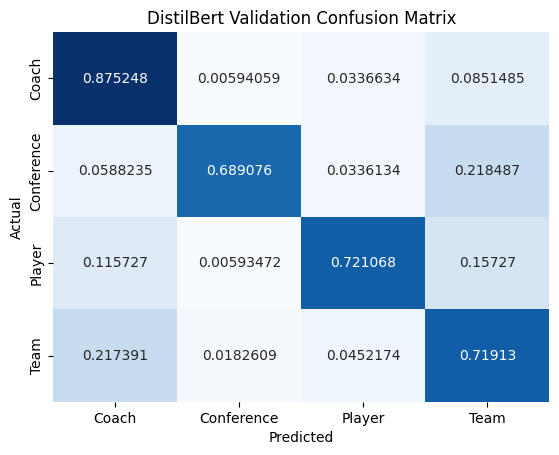

In [150]:
confusion_matrix = metrics.confusion_matrix(eval_review['label_str'],eval_review['pred_str'],normalize='true')
cm_dbert_df = pd.DataFrame(confusion_matrix,index=['Coach','Conference','Player','Team'],columns=['Coach','Conference','Player','Team'])
sns.heatmap(cm_dbert_df,fmt='g',cmap='Blues',annot=True,cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('DistilBert Validation Confusion Matrix')
plt.show();

Holdout Set Evaluation Distilbert

In [155]:

prep_test_ho = prep_test.copy()
prep_test_ho.rename(columns={'class':'labels_str'},inplace=True)
prep_test_ho.loc[:,'labels'] = prep_test_ho['labels_str'].apply(lambda word: label_num[word])
x_tok_holdout = MultiLabelDataset(dataframe=prep_test_ho,tokenizer=tokenizer_disbert,max_len=MAX_LEN)
ho_loader = DataLoader(x_tok_holdout, **test_params)
_, holdout_loss = validate_bert(model,ho_loader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss Epoch: 0.48077822374099444
Validation Accuracy Epoch: 77.52161383285302


In [158]:
ho_review = pd.DataFrame(holdout_loss)
ho_review['pred_str']= ho_review['pred'].apply(lambda x: list(label_num.keys())[list(label_num.values()).index(x)])
ho_review['label_str']= ho_review['label'].apply(lambda x: list(label_num.keys())[list(label_num.values()).index(x)])
ho_review[ho_review['pred']!=ho_review['label']].sort_values(by=['loss'],ascending=False).head(10)

Comment  \
46     three of those four are verified prick ##s and i ##zzo has probably done just enough with his “ tough love ” to be in that category for a clean sweep . not sure if that ’ s who i ’ d want to set the standard . plenty of winning coaches aren ’ t like that . i haven ’ t followed him closely enough to know any specific things he has done to be an asshole on par with those guys , but you have to be kind of be an asshole to be as animated as he is non stop , as if every call against uc ##on ##n is a hate crime . you can clearly see him cursing the officials with that gaping ma ##w open all the...   
666    i just wonder about ba ##cot and un ##c stopping them . that ’ s if bam ##a gets there though . big if , if we ’ re being honest .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ...   
1286   always been a huge fan of cal at kentucky . seems to be a good dude that players enjoy playing for and damn he ’ s had some electric teams there i was obsessed with that john wall team                                                                                                                                                                                                                                                                                                                                                                                                                           ...   
1661     when i think of good uc ##on ##n football , i think donald brown . does he essentially represent that era ?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1303   i think there ' s a better chance of say ##aka getting a good ending in wal ##pur ##gis ##nac ##ht rising than hurley to kentucky .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ...   
971    yeah to be honest i ’ d be pretty nervous if we ’ re playing 26 - 4 princeton in the first round , but no way we ’ re losing to the third best team in ivy who needs a miracle to beat brown lo ##l                                                                                                                                                                                                                                                                                                                                                                                                                ...   
1267   fun fact : i pick the ivy champ to win its first game every year . i feel like that one pays off a lot . kind of a waste to do it against a team like auburn since there ' s essentially no way they lose to yale , but i can ' t help myself .                                                                                         

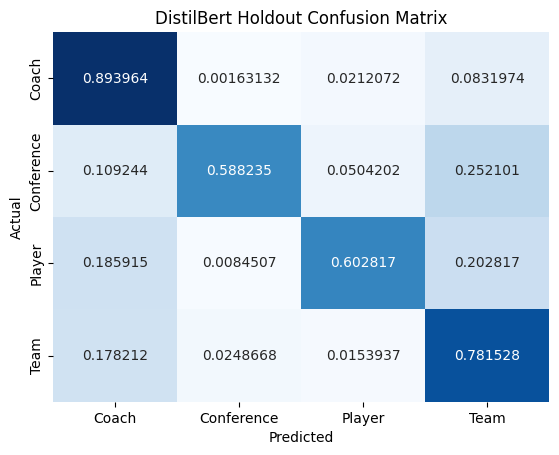

In [171]:
confusion_matrix = metrics.confusion_matrix(ho_review['label_str'],ho_review['pred_str'],normalize='true')
cm_dbert_ho_df = pd.DataFrame(confusion_matrix,index=['Coach','Conference','Player','Team'],columns=['Coach','Conference','Player','Team'])
sns.heatmap(cm_dbert_ho_df,fmt='g',cmap='Blues',annot=True,cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('DistilBert Holdout Confusion Matrix')
plt.show();

### Named Entity Recognition

In [ ]:
prep_ner_df = prep_df.copy()
prep_test_ner_df = prep_test.copy()

In [ ]:
ner_df = labeled_df.merge(prep_ner_df.groupby('Row')['ner_tag'].apply(list),how='inner',left_on='Row',right_on='Row')
ner_df.head()

Unnamed: 0  \
0           0   
1          11   
2          12   
3          16   
4          17   

                                                                                               Comments  \
0                                   Can’t believe I have a reason to watch Selection Sunday.  Go Pack!!   
1                                                                                 This sucks thanks UNC   
2  Can't wait to watch UNC be gifted the last #1 seed when Iowa State legitimately earned it yesterday.   
3                                                                                     Fly Peacocks Fly!   
4                                                                    Guys cheers for Uconn , gather up!   

            Entity       Class  Row  ent_semi_cnt  class_semi_cnt  semi_diff  \
0             Pack        Team    0             0               0          0   
1              UNC        Team   11             0               0          0   
2  UNC; Iowa State  Team; Team   12             1               1          0   
3         Peacocks        Team   16             0               0          0   
4            Uconn        Team   17             0               0          0   

          ner_tag  
0         [I-ORG]  
1         [I-ORG]  
2  [I-ORG, I-ORG]  
3         [I-ORG]  
4         [I-ORG]

In [ ]:
prep_test_ner_df.loc[:,'ner_tag'] = prep_test_ner_df['class'].apply(lambda word: 'B-Misc' if word=='Conference' else 'B-PER' if re.search(word,'Coach|Player') else 'I-ORG')
test_ner_df = test_df.merge(prep_test_ner_df.groupby('Row')['ner_tag'].apply(list),how='inner',left_on='Row',right_on='Row')

In [ ]:
ner_test_text = test_ner_df["Comments"].values.tolist()
text_test_ner_tokenized = dbert_uncased_tokenizer(ner_test_text, padding = "max_length" , truncation = True, return_tensors = "pt" )

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pas_with_label(btch):
  features = [dict(zip(btch,t) for t in zip(*batch.values))]

Testing a Named Entity Recognition Solution (Politi)

In [ ]:
def tags_mapping(tags_series : pd.Series):

  unique_tags = set()

  for tag_list in tags_series:
    for tag in tag_list:
      unique_tags.add(tag.split())


  tag2idx = {k:v for v,k in enumerate(sorted(unique_tags))}
  idx2tag = {k:v for v,k in tag2idx.items()}

  unseen_label = -100

  return tag2idx, idx2tag, unseen_label, unique_tags
def match_tokens_labels(tokenized_input, tags, ignore_token = -100):
  word_ids = tokenized_input.word_ids()

  previous_word_idx = None
  label_ids = []

  for word_idx in word_ids:

      if word_idx is None:
          label_ids.append(ignore_token)
      else :
          try:
            reference_tag = tags[word_idx]
            label_ids.append(tag2idx[reference_tag])
          except:
            label_ids.append(ignore_token)


      previous_word_idx = word_idx

  return label_ids
def tag_labeler(tags : str, tag2idx : dict):
    return [tag2idx[tag] if tag in tag2idx else unseen_label for tag in tags]

In [ ]:
class DistilbertNER(nn.Module):

  def __init__(self, tokens_dim):
    super(DistilbertNER,self).__init__()
    self.pretrained = DistilBertForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels = tokens_dim)


  def forward(self, input_ids, attention_mask, labels = None):
    if labels is None:
      ValueError("Labels are required")
    out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask , labels = labels)
    return out
class NamedEntityDataset(torch.utils.data.Dataset):

  def __init__(self, df,tknzer,tag_labels):
    tags_list = tag_labels.values.tolist()
    texts = df["Comments"].values.tolist()

    self.texts = [tknzer(text, padding = "max_length", truncation = True, return_tensors = "pt") for text in texts]
    self.labels = [match_tokens_labels(text, tags) for text,tags in zip(self.texts, tags_list)]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    batch_text = self.texts[idx]
    batch_labels = self.labels[idx]

    return batch_text, torch.LongTensor(batch_labels)
class MetricsTracking():

  def __init__(self):

    self.total_acc = 0
    self.total_f1 = 0
    self.total_precision = 0
    self.total_recall = 0

  def update_metrics(self, predictions, labels , ignore_token = -100):

    predictions = predictions.flatten()
    labels = labels.flatten()

    predictions = predictions[labels != ignore_token]
    labels = labels[labels != ignore_token]

    predictions = predictions.to("cpu")
    labels = labels.to("cpu")

    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = "macro")
    precision = precision_score(labels, predictions, average = "macro")
    recall = recall_score(labels, predictions, average = "macro")

    self.total_acc  += acc
    self.total_f1 += f1
    self.total_precision += precision
    self.total_recall  += recall

  def return_avg_metrics(self,data_loader_size):
    n = data_loader_size
    metrics = {
        "acc": round(self.total_acc / n ,3),
        "f1": round(self.total_f1 / n, 3),
        "precision" : round(self.total_precision / n, 3),
        "recall": round(self.total_recall / n, 3)
          }
    return metrics
def train_loop(model, train_dataset, dev_dataset, optimizer,  batch_size, epochs):

  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  for epoch in range(epochs) :

    train_metrics = MetricsTracking()
    total_loss_train = 0

    model.train()

    for train_data, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      mask = train_data['attention_mask'].squeeze(1).to(device)
      input_id = train_data['input_ids'].squeeze(1).to(device)

      optimizer.zero_grad()

      output = model(input_id, mask, train_label)
      loss, logits = output.loss, output.logits
      predictions = logits.argmax(dim= -1)

      train_metrics.update_metrics(predictions, train_label)
      total_loss_train += loss.item()

      loss.backward()
      optimizer.step()

    model.eval()

    dev_metrics = MetricsTracking()
    total_loss_dev = 0

    with torch.no_grad():
      for dev_data, dev_label in dev_dataloader:

        dev_label = dev_label.to(device)

        mask = dev_data['attention_mask'].squeeze(1).to(device)
        input_id = dev_data['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask, dev_label)
        loss, logits = output.loss, output.logits

        predictions = logits.argmax(dim= -1)

        dev_metrics.update_metrics(predictions, dev_label)
        total_loss_dev += loss.item()

    train_results = train_metrics.return_avg_metrics(len(train_dataloader))
    dev_results = dev_metrics.return_avg_metrics(len(dev_dataloader))

    print(f"TRAIN \nLoss: {total_loss_train / len(train_dataset)} \nMetrics {train_results}\n" )
    print(f"VALIDATION \nLoss {total_loss_dev / len(dev_dataset)} \nMetrics{dev_results}\n" )
    return train_results, dev_results



In [ ]:
X_ner_train, X_ner_val, y_ner_train, y_ner_val = train_test_split(ner_df[['Comments','Entity']], ner_df['ner_tag'], test_size=0.3, random_state=5)

In [ ]:
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(y_ner_train)


y_ner_train['labels'] = y_ner_train.apply(lambda tags : tag_labeler(tags, tag2idx))
y_ner_val['labels'] = y_ner_val.apply(lambda tags : tag_labeler(tags, tag2idx))
ner_text = X_ner_train["Comments"].values.tolist()

dbert_uncased_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_ner_tokenized = dbert_uncased_tokenizer(ner_text, padding = "max_length" , truncation = True, return_tensors = "pt" )

#mapping token to original word
ner_word_ids = text_ner_tokenized.word_ids()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = DistilbertNER(len(unique_tags))


#datasets
train_dataset = NamedEntityDataset(X_ner_train,dbert_uncased_tokenizer,y_ner_train)
dev_dataset = NamedEntityDataset(X_ner_val,dbert_uncased_tokenizer,y_ner_val)

lr = 1e-2
optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)

parameters = {
    "model": model,
    "train_dataset": train_dataset,
    "dev_dataset" : dev_dataset,
    "optimizer" : optimizer,
    "batch_size" : 6,
    "epochs" : 4
}

train_metrics, dev_metrics = train_loop(**parameters)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/586 [00:04<46:36,  4.78s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/586 [00:13<43:45,  4.50s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%| 

TRAIN 
Loss: 0.15052006879836805 
Metrics {'acc': 0.535, 'f1': 0.354, 'precision': 0.339, 'recall': 0.467}

VALIDATION 
Loss 0.14645668713853338 
Metrics{'acc': 0.524, 'f1': 0.397, 'precision': 0.439, 'recall': 0.511}



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_metrics, dev_metrics

({'acc': 0.535, 'f1': 0.354, 'precision': 0.339, 'recall': 0.467},
 {'acc': 0.524, 'f1': 0.397, 'precision': 0.439, 'recall': 0.511})

#### Alternative Text Classification

*   TFIDF
*   Count Vectorizer


In [161]:
stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemma = WordNetLemmatizer()

In [162]:
def tokenize_text_nltk(text):
  tkns = nltk.word_tokenize(text)
  cln_tkns = [tkn.strip() for tkn in tkns]
  return cln_tkns
def tag_pos(text):
  pos_tag_txt = nltk.pos_tag(text)
  tag_lw_text = [(word.lower(), penn_to_wn_tags(pos_tag))for word, pos_tag in pos_tag_txt]
  return tag_lw_text
def penn_to_wn_tags(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return None
def lemmatize_text(text):
    pos_tagged_text = tag_pos(tokenize_text_nltk(text))
    lemmatized_tokens = [wordnet_lemma.lemmatize(word, pos_tag) if pos_tag
                         else word for word, pos_tag in pos_tagged_text]
    lemma_txt = ' '.join(lemmatized_tokens)
    return lemma_txt

def remove_sw_sc(text):
    tkns = tokenize_text_nltk(text)
    stops = set(nltk.corpus.stopwords.words('english'))
    filt_tks = [tk for tk in tkns if tk not in stops]
    filt_text = ' '.join(filt_tks)
    return filt_text

In [163]:
def prepare_text(text,return_token=False):
  text_data = []
  for t in text:
    t = remove_sw_sc(t)
    t = lemmatize_text(t)
    if return_token:
      t = tokenize_text_nltk(t)
      text_data.append(t)
    else:
      text_data.append(t)

  return text_data

Testing Text Data Preparation Functions

In [ ]:
prepare_text(['the sly fox went down the river','leave it to beaver hero'],True)


[['sly', 'fox', 'go', 'river'], ['leave', 'beaver', 'hero']]

Feature Extraction and Evaluation Functions

In [167]:
def display_features(features, feature_names):
    df = pd.DataFrame(data=features, columns=feature_names)
    print(df)
def bag_words_extractor(corpus, ngram_range=(1,1)):
  vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
  features = vectorizer.fit_transform(corpus)
  return vectorizer, features
def tfidf_transformer(input_matrix):
  tfidf = TfidfTransformer(norm='l2',smooth_idf=True, use_idf=True)
  tfidf_mat = tfidf.fit_transform(input_matrix)
  return tfidf, tfidf_mat
def tdidf_vectorizer(input_matrix,test=False,vect=None):
  if test:
    x_tdidf = vect.transform(input_matrix)
    tfidf_vect = vect
  else:
    tfidf_vect = TfidfVectorizer(norm='l2',stop_words='english')
    x_tdidf = tfidf_vect.fit_transform(input_matrix)
  return tfidf_vect, x_tdidf

def get_metrics(actuals, predicted):
  #print(actuals,predicted)
  eval_metrics = {'Accuracy': np.round(metrics.accuracy_score(actuals,predicted),2),
   'Precision': np.round(metrics.precision_score(actuals,predicted,average='weighted'),2),
   'Recall': np.round(metrics.recall_score(actuals,predicted,average='weighted'),2),
   'F1 Score': np.round(metrics.f1_score(actuals,predicted, average='weighted'),2)}
  return pd.DataFrame([eval_metrics])
def train_evaluate_model(classifier,preds, targets,val,v_targets,testset=False):
  classifier.fit(preds, targets)
  predictions = classifier.predict(val)
  cm = metrics.confusion_matrix(v_targets,predictions,normalize='true')
  return cm, get_metrics(actuals=v_targets,predicted=predictions)
def cv_scores(mod,x,y):
  scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro',
            'f1_macro':'f1_macro',
            'roc_auc':'roc_auc'}
  return cross_validate(mod, x, y, scoring=scoring, cv=5, return_train_score=True)

Reviewing word counts

In [165]:
x_T_tk = prepare_text(prep_df['Comments'])

In [ ]:
x_T_tk[0:5]

['can ’ believe i reason watch selection sunday . go pack ! !',
 'this suck thanks unc',
 "ca n't wait watch unc gift last # 1 seed iowa state legitimately earn yesterday .",
 "ca n't wait watch unc gift last # 1 seed iowa state legitimately earn yesterday .",
 'fly peacock fly !']

In [ ]:
test_vect_nodoc = TfidfVectorizer(norm='l2',stop_words='english')
test_vect_09 = TfidfVectorizer(norm='l2',max_df=0.9,min_df=3,stop_words='english')
test_vect_091 = TfidfVectorizer(norm='l2',max_df=0.9,stop_words='english')
test_vect_08 = TfidfVectorizer(norm='l2',max_df=0.8,min_df=3,stop_words='english')
test_vect_07 = TfidfVectorizer(norm='l2',max_df=0.7,min_df=3,stop_words='english')
test_vect_06_ngram2 = TfidfVectorizer(norm='l2',max_df=0.7,min_df=3,stop_words='english',ngram_range=(1,2))

In [ ]:
tv = test_vect_nodoc.fit_transform(x_T_tk)
tv09 = test_vect_09.fit_transform(x_T_tk)
tv091 = test_vect_091.fit_transform(x_T_tk)
tv08 = test_vect_08.fit_transform(x_T_tk)
tv07 = test_vect_07.fit_transform(x_T_tk)
tv06 = test_vect_06_ngram2.fit_transform(x_T_tk)

In [ ]:
print('100% with Unigrams',f"n_samples: {tv.shape[0]}, n_features: {tv.shape[1]}")
print('90% with Unigrams and 3+ occurrences',f"n_samples: {tv09.shape[0]}, n_features: {tv09.shape[1]}")
print('90% with Unigrams',f"n_samples: {tv091.shape[0]}, n_features: {tv091.shape[1]}")
print('80% with Unigrams and 3+ occurrences',f"n_samples: {tv08.shape[0]}, n_features: {tv08.shape[1]}")
print('70% with Unigrams and 3+ occurrences',f"n_samples: {tv07.shape[0]}, n_features: {tv07.shape[1]}")
print('60% with Bigrams and 3+ occurrences',f"n_samples: {tv06.shape[0]}, n_features: {tv06.shape[1]}")

100% with Unigrams n_samples: 10553, n_features: 8451
90% with Unigrams and 3+ occurrences n_samples: 10553, n_features: 5880
90% with Unigrams n_samples: 10553, n_features: 8451
80% with Unigrams and 3+ occurrences n_samples: 10553, n_features: 5880
70% with Unigrams and 3+ occurrences n_samples: 10553, n_features: 5880
60% with Bigrams and 3+ occurrences n_samples: 10553, n_features: 37067


A quick comparison of the potential feature space when evaluating the full dataset leads to some interesting results. Bigrams cause a substantial increase in the number of features which will likely slow down model performance. Ultimately, when one limits the number of terms with an upper and lower floor it does not seem to dramatically alter the feature space and the parameters will not need to be set.

In [169]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
x_T = prep_df['Comments']
y_T = prep_df['class']
cv.get_n_splits(x_T,y_T)

5

In [170]:
mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge')
mnb_cms = []
svm_cms = []

ridge_clf = RidgeClassifier(tol=1e-2,solver='sparse_cg')
lr_clf = LogisticRegression(C=5,max_iter=1000)
ridge_cms = []
lr_cms = []
cm = {}
full_class_df = pd.DataFrame()
for fold, (train, test) in enumerate(cv.split(x_T, y_T)):
  #if fold==0:
  prep_train_data = prepare_text(x_T[train])
  prep_test_data = prepare_text(x_T[test])
  tfidf_train_vect, tfidf_train_preds = tdidf_vectorizer(prep_train_data)
  tfidf_test_vect, tfidf_test_preds = tdidf_vectorizer(prep_test_data,test=True,vect=tfidf_train_vect)
  mnb_cm,eval_mnb_df = train_evaluate_model(mnb,tfidf_train_preds,y_T[train],tfidf_test_preds,y_T[test])
  svm_cm, eval_svm_df = train_evaluate_model(svm,tfidf_train_preds,y_T[train],tfidf_test_preds,y_T[test])

  row_mnb = 'Multi-Bayes_' + str(fold+1)
  row_svm = 'SVM_'+ str(fold+1)
  eval_mnb_df.index = [row_mnb]
  eval_svm_df.index = [row_svm]
  mnb_cms.append(mnb_cm)
  svm_cms.append(svm_cm)

  ridge_cm,eval_ridge_df = train_evaluate_model(ridge_clf,tfidf_train_preds,y_T[train],tfidf_test_preds,y_T[test])
  lr_cm, eval_lr_df = train_evaluate_model(lr_clf,tfidf_train_preds,y_T[train],tfidf_test_preds,y_T[test])
  row_ridge = 'Ridge Regression_' + str(fold+1)
  row_lr = 'Logistic Regression_'+ str(fold+1)
  eval_ridge_df.index = [row_ridge]
  eval_lr_df.index = [row_lr]
  ridge_cms.append(ridge_cm)
  lr_cms.append(lr_cm)
  cm[row_mnb] = mnb_cm
  cm[row_svm] = svm_cm
  cm[row_ridge] = ridge_cm
  cm[row_lr] = lr_cm
  full_class_df = pd.concat([full_class_df,eval_mnb_df,eval_svm_df,eval_ridge_df,eval_lr_df])

In [172]:
full_class_df['fold_name'] = full_class_df.index
full_class_df['classifier'] = full_class_df['fold_name'].apply(lambda x: x.split('_')[0])
full_class_df['fold'] = full_class_df['fold_name'].apply(lambda x: int(x.split('_')[1]))
full_class_df.sort_values(by='F1 Score',ascending=False)

Accuracy  Precision  Recall  F1 Score  \
SVM_4                      0.72       0.72    0.72      0.72   
SVM_3                      0.72       0.71    0.72      0.71   
Ridge Regression_4         0.71       0.71    0.71      0.71   
SVM_1                      0.71       0.70    0.71      0.70   
Ridge Regression_3         0.70       0.70    0.70      0.70   
Logistic Regression_4      0.71       0.70    0.71      0.70   
SVM_2                      0.71       0.70    0.71      0.70   
Ridge Regression_1         0.69       0.69    0.69      0.69   
SVM_5                      0.70       0.69    0.70      0.69   
Logistic Regression_1      0.69       0.69    0.69      0.69   
Logistic Regression_3      0.69       0.69    0.69      0.69   
Ridge Regression_2         0.69       0.69    0.69      0.69   
Logistic Regression_2      0.68       0.68    0.68      0.68   
Logistic Regression_5      0.69       0.68    0.69      0.68   
Ridge Regression_5         0.69       0.68    0.69      0.68   
Multi-Bayes_4              0.67       0.70    0.67      0.64   
Multi-Bayes_3              0.67       0.70    0.67      0.63   
Multi-Bayes_1              0.66       0.68    0.66      0.62   
Multi-Bayes_5              0.65       0.68    0.65      0.61   
Multi-Bayes_2              0.64       0.67    0.64      0.60   

                                   fold_name           classifier  fold  
SVM_4                                  SVM_4                  SVM     4  
SVM_3                                  SVM_3                  SVM     3  
Ridge Regression_4        Ridge Regression_4     Ridge Regression     4  
SVM_1                                  SVM_1                  SVM     1  
Ridge Regression_3        Ridge Regression_3     Ridge Regression     3  
Logistic Regression_4  Logistic Regression_4  Logistic Regression     4  
SVM_2                                  SVM_2                  SVM     2  
Ridge Regression_1        Ridge Regression_1     Ridge Regression     1  
SVM_5                                  SVM_5                  SVM     5  
Logistic Regression_1  Logistic Regression_1  Logistic Regression     1  
Logistic Regression_3  Logistic Regression_3  Logistic Regression     3  
Ridge Regression_2        Ridge Regression_2     Ridge Regression     2  
Logistic Regression_2  Logistic Regression_2  Logistic Regression     2  
Logistic Regression_5  Logistic Regression_5  Logistic Regression     5  
Ridge Regression_5        Ridge Regression_5     Ridge Regression     5  
Multi-Bayes_4                  Multi-Bayes_4          Multi-Bayes     4  
Multi-Bayes_3                  Multi-Bayes_3          Multi-Bayes     3  
Multi-Bayes_1                  Multi-Bayes_1          Multi-Bayes     1  
Multi-Bayes_5                  Multi-Bayes_5          Multi-Bayes     5  
Multi-Bayes_2                  Multi-Bayes_2          Multi-Bayes     2

In [173]:
full_class_df.groupby('classifier')[['Accuracy','F1 Score']].mean().sort_values(by='F1 Score',ascending=False)

Accuracy  F1 Score
classifier                             
SVM                     0.712     0.704
Ridge Regression        0.696     0.694
Logistic Regression     0.692     0.688
Multi-Bayes             0.658     0.620

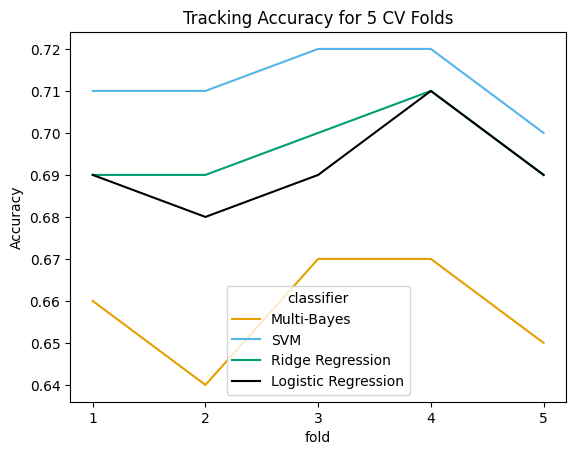

In [174]:
sns.lineplot(data=full_class_df,x='fold',y='Accuracy',hue='classifier',palette=['#E69F00','#56B4E9','#009E73','#000000']).set_title('Tracking Accuracy for 5 CV Folds')
plt.xticks(range(1,6,1))
plt.show();

In [180]:
cm_cols = list(y_T[test].groupby(y_T[test]).count().index)
cm_cols = [c.replace('Conference','Conf') for c in cm_cols]
def create_cm_df(cm,cols):
  cm_df = pd.DataFrame(cm,columns=cols,index=cols)
  rnd_cm_df = cm_df.round(5)
  return rnd_cm_df


mnb_cm_df1 = create_cm_df(mnb_cms[0],cols=cm_cols)
mnb_cm_df2 = create_cm_df(mnb_cms[1],cols=cm_cols)
mnb_cm_df3 = create_cm_df(mnb_cms[2],cols=cm_cols)
mnb_cm_df4 = create_cm_df(mnb_cms[3],cols=cm_cols)
mnb_cm_df5 = create_cm_df(mnb_cms[4],cols=cm_cols)
lr_cm_df1 = create_cm_df(lr_cms[0],cols=cm_cols)
lr_cm_df2 = create_cm_df(lr_cms[1],cols=cm_cols)
lr_cm_df3 = create_cm_df(lr_cms[2],cols=cm_cols)
lr_cm_df4 = create_cm_df(lr_cms[3],cols=cm_cols)
lr_cm_df5 = create_cm_df(lr_cms[4],cols=cm_cols)
svm_cm_df1 = create_cm_df(svm_cms[0],cols=cm_cols)
svm_cm_df2 = create_cm_df(svm_cms[1],cols=cm_cols)
svm_cm_df3 = create_cm_df(svm_cms[2],cols=cm_cols)
svm_cm_df4 = create_cm_df(svm_cms[3],cols=cm_cols)
svm_cm_df5 = create_cm_df(svm_cms[4],cols=cm_cols)
ridge_cm_df1 = create_cm_df(ridge_cms[0],cols=cm_cols)
ridge_cm_df2 = create_cm_df(ridge_cms[1],cols=cm_cols)
ridge_cm_df3 = create_cm_df(ridge_cms[2],cols=cm_cols)
ridge_cm_df4 = create_cm_df(ridge_cms[3],cols=cm_cols)
ridge_cm_df5 = create_cm_df(ridge_cms[4],cols=cm_cols)


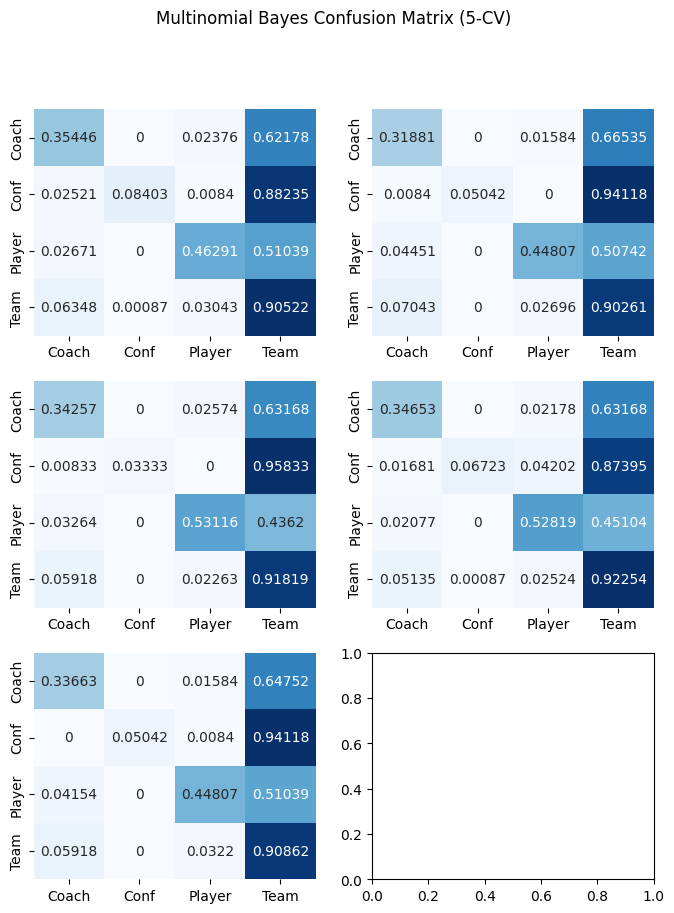

In [181]:
fig, (ax1,ax2,ax3) = plt.subplots(3,2,figsize=(8,10))
sns.heatmap(mnb_cm_df1,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[0])
sns.heatmap(mnb_cm_df2,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[1])
sns.heatmap(mnb_cm_df3,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[0])
sns.heatmap(mnb_cm_df4,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[1])
sns.heatmap(mnb_cm_df5,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax3[0])
plt.suptitle('Multinomial Bayes Confusion Matrix (5-CV)')
plt.show();

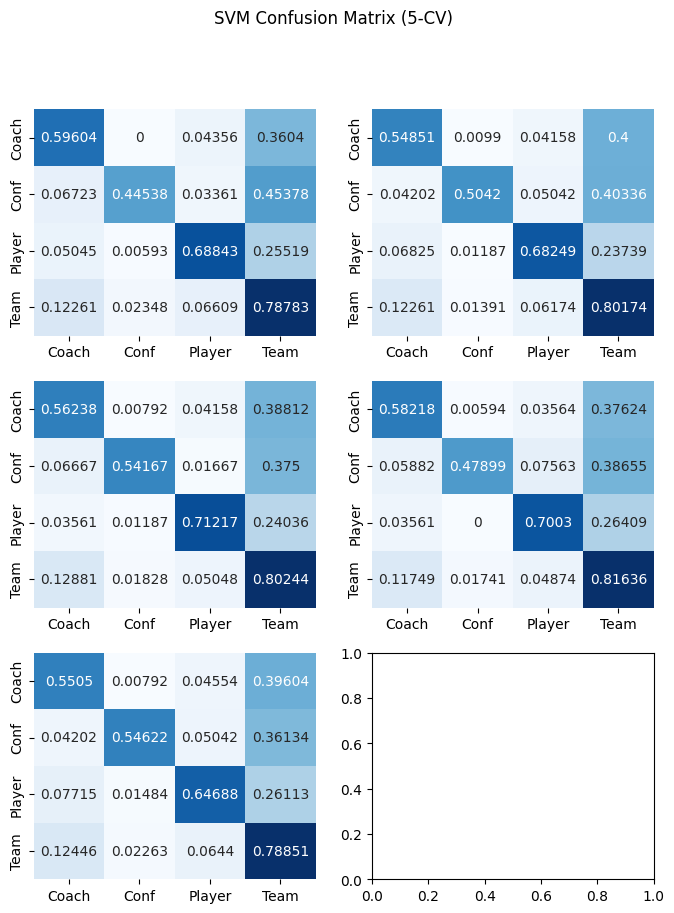

In [182]:
fig, (ax1,ax2,ax3) = plt.subplots(3,2,figsize=(8,10))
sns.heatmap(svm_cm_df1,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[0])
sns.heatmap(svm_cm_df2,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[1])
sns.heatmap(svm_cm_df3,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[0])
sns.heatmap(svm_cm_df4,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[1])
sns.heatmap(svm_cm_df5,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax3[0])
plt.suptitle('SVM Confusion Matrix (5-CV)')
plt.show();

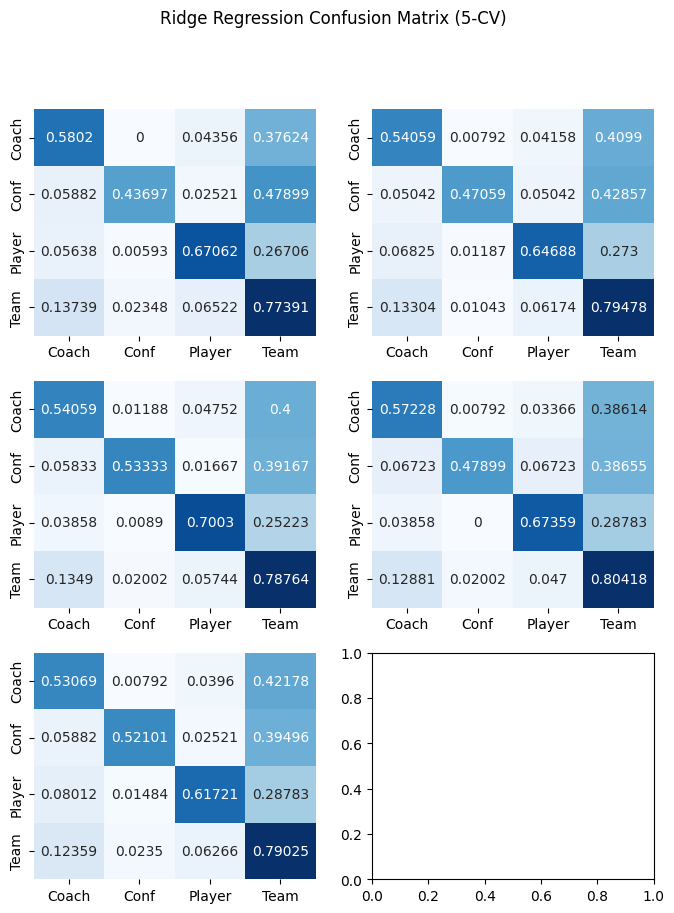

In [183]:
fig, (ax1,ax2,ax3) = plt.subplots(3,2,figsize=(8,10))
sns.heatmap(ridge_cm_df1,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[0])
sns.heatmap(ridge_cm_df2,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[1])
sns.heatmap(ridge_cm_df3,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[0])
sns.heatmap(ridge_cm_df4,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[1])
sns.heatmap(ridge_cm_df5,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax3[0])
plt.suptitle('Ridge Regression Confusion Matrix (5-CV)')
plt.show();

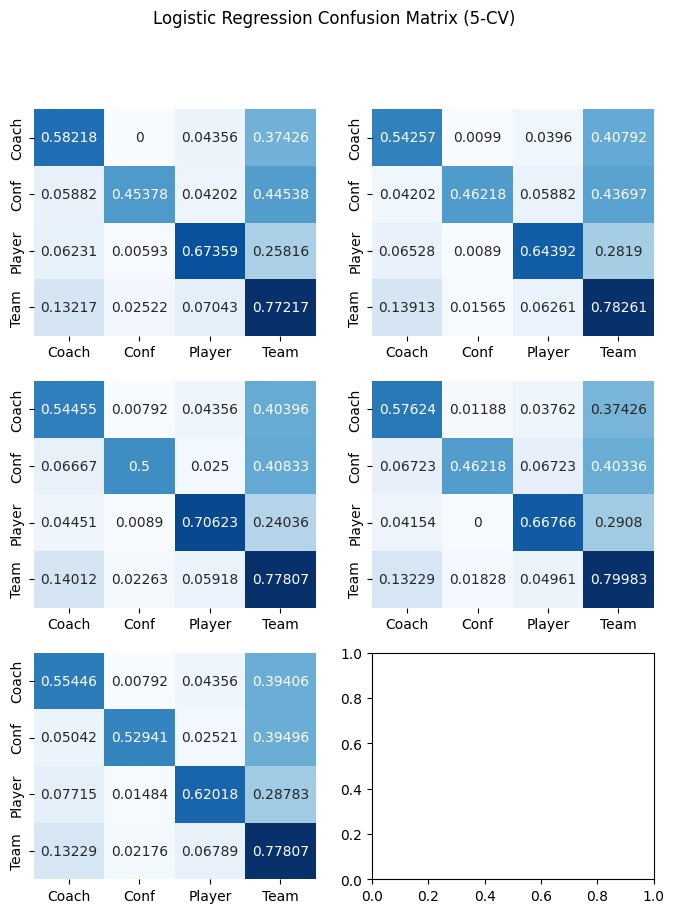

In [184]:
fig, (ax1,ax2,ax3) = plt.subplots(3,2,figsize=(8,10))
sns.heatmap(lr_cm_df1,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[0])
sns.heatmap(lr_cm_df2,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[1])
sns.heatmap(lr_cm_df3,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[0])
sns.heatmap(lr_cm_df4,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[1])
sns.heatmap(lr_cm_df5,fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax3[0])
plt.suptitle('Logistic Regression Confusion Matrix (5-CV)')
plt.show();

In [ ]:
list(y_T.groupby(y_T).count())

[2525, 596, 1685, 5747]

In [ ]:
true_k = 4
for seed in range(5):
    kmeans = KMeans(
        n_clusters=4,
        max_iter=100,
        n_init=1,
        random_state=seed).fit(tv)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")

print("True number of documents in each category according to the class labels: "f"{list(y_T.groupby(y_T).count())}"
)

Number of elements assigned to each cluster: [1555  902  617 7479]
Number of elements assigned to each cluster: [2502  922 5197 1932]
Number of elements assigned to each cluster: [2808  525  884 6336]
Number of elements assigned to each cluster: [5908 2038  898 1709]
Number of elements assigned to each cluster: [ 614 1415  957 7567]
True number of documents in each category according to the class labels: [2525, 596, 1685, 5747]


Reduction of Sparse Matrix Dimentions



*  Using SVD to apply linear combinations that represent variance of original sparse matrix
*   Cluster on fewer dimensions and potential identification of words central to the four labeled clusters from the dataset



In [ ]:
## Utilizing SciKit Learn guidance
svd_pipeline = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

x_vect_lsa = svd_pipeline.fit_transform(tv)
explained_variance = svd_pipeline[0].explained_variance_ratio_.sum()

print(f"Explained variance of the remaining dimensions after SVD reductions: {explained_variance * 100:.1f}%")

Explained variance of the remaining dimensions after SVD reductions: 25.6%


In [ ]:
def fit_clusters(kmeans, preds,target, name=None, n_runs=5):
    evaluations = []
    evaluations_std = []
    #Repurposed from SciKit Learn LSA Kmeans TFIDF
    name = kmeans.__class__.__name__ if name is None else name

    train_times = []
    kmetrics = defaultdict(list)
    for r in range(n_runs):
        kmeans.fit(preds)
        kmetrics["Homogeneity"].append(metrics.homogeneity_score(target, kmeans.labels_))
        kmetrics["Completeness"].append(metrics.completeness_score(target, kmeans.labels_))
        kmetrics["V-measure"].append(metrics.v_measure_score(target, kmeans.labels_))
        kmetrics["Silhouette Coefficient"].append(metrics.silhouette_score(preds, kmeans.labels_, sample_size=2000))
    eval = {}
    eval_std = {}
    for k, v in kmetrics.items():
        mean_sc, std_sc = np.mean(v), np.std(v)
        eval[k] = mean_sc
        eval_std[k] = std_sc
    evaluations.append(eval)
    evaluations_std.append(eval_std)
    return evaluations, evaluations_std

In [ ]:
kmeans_svd = KMeans(n_clusters=4,max_iter=50,n_init=1)
km_svd_eval, km_svd_eval_std = fit_clusters(kmeans_svd, x_vect_lsa,y_T, name="KMeans_SVD")

In [ ]:
inv_k_centroids = svd_pipeline[0].inverse_transform(kmeans_svd.cluster_centers_)
centroids_desc = inv_k_centroids.argsort()[:, ::-1]
terms = test_vect_nodoc.get_feature_names_out()


for i in range(4):
    print(f"Cluster {i}: ", end="")
    for idx in centroids_desc[i, :10]:
        print(f"{terms[idx]} ", end="")
    print()

Cluster 0: blue blood uconn duke title win ucla championship year program 
Cluster 1: purdue team game edey uconn play guard year think good 
Cluster 2: kentucky coach hurley big state drew uconn like think baylor 
Cluster 3: year cal uk fan coach kentucky like think win time 


When evaluating the most central terms that exist per the K-Means algorithm it is interesting to see that there are a mix of words within each cluster that a human labeler would typically classify as a reference to a coach, team or player. This result speaks in some way to the limitation of using dimension reduction to try to measure centrality especially given that in this case only ~25% of the variance is represented

In [ ]:
def plot_impactful_terms(classifier,x_train,uniq_labels,vectorizer,plot_title):
    # repurposed from SciKit Learn classifition of text documents using sparse features

    classifier_coef = classifier.coef_
    average_feature_effects = classifier_coef * np.asarray(x_train.mean(axis=0)).ravel()
    feat = vectorizer.get_feature_names_out()
    for i, label in enumerate(uniq_labels):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feat[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feat[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feat[top_indices]

    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(uniq_labels):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")
    ax.set_title(plot_title)

    plt.show();
    return ax,top5

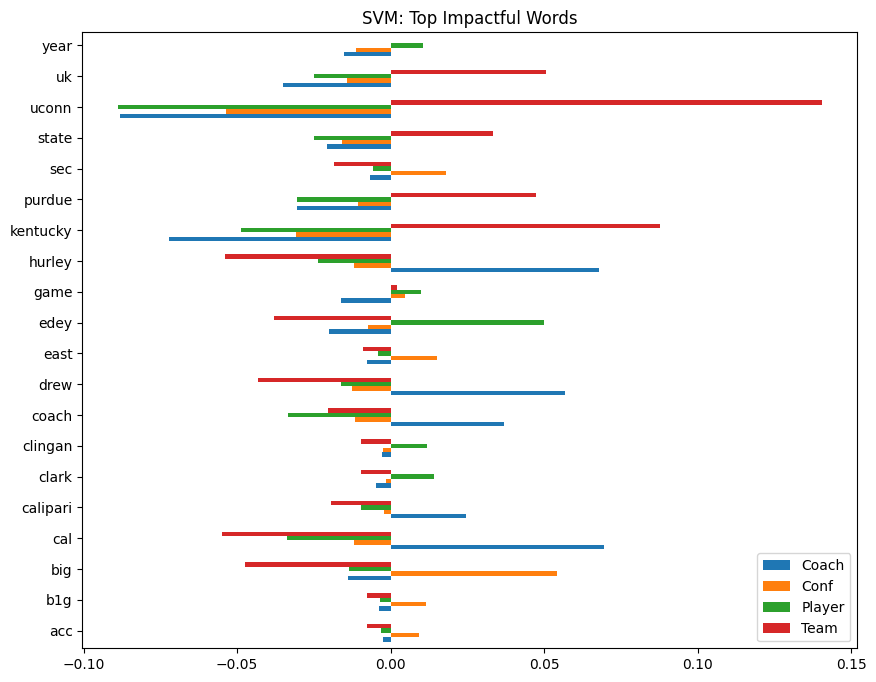

In [ ]:
ax_top,top_terms = plot_impactful_terms(classifier=svm,x_train=tfidf_train_preds,uniq_labels=cm_cols,vectorizer=tfidf_train_vect,plot_title="SVM: Top Impactful Words")

The most influential terms appear to be some of the most frequent ones that appeared in the Reddit posts which in some ways makes sense given that the in sample corpora drives the vectorized sparse matrix from the TF-IDF algorithm. Only a few terms that appear on this graph are surprising as the word "player" was not expected to be referenced so heavily instead of a player's name. The expectation would be that posts from users will instead specific call out the name(s) of players when discussing them.

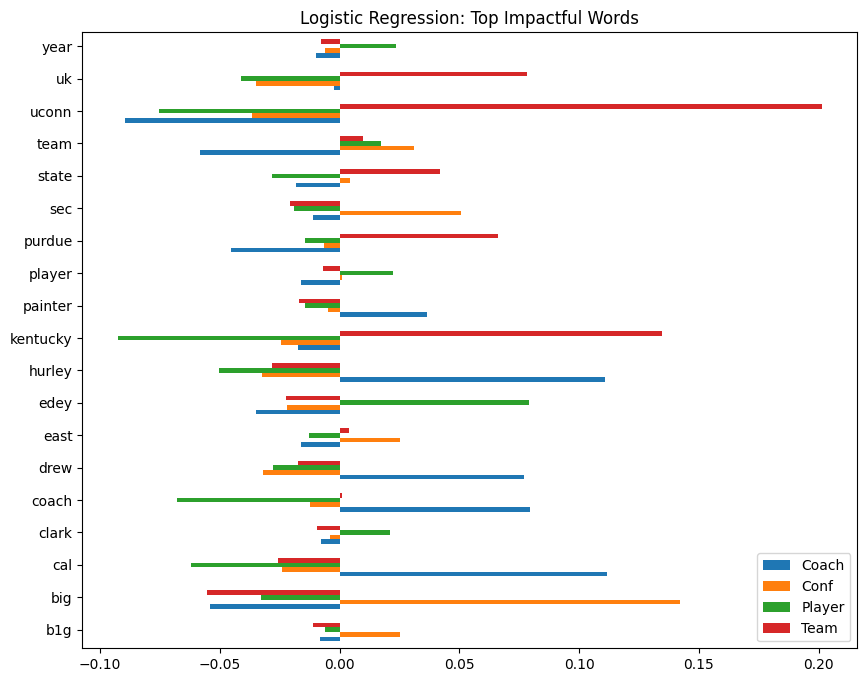

In [ ]:
ax_top,top_terms = plot_impactful_terms(classifier=lr_clf,x_train=tfidf_train_preds,uniq_labels=cm_cols,vectorizer=tfidf_train_vect,plot_title="Logistic Regression: Top Impactful Words")

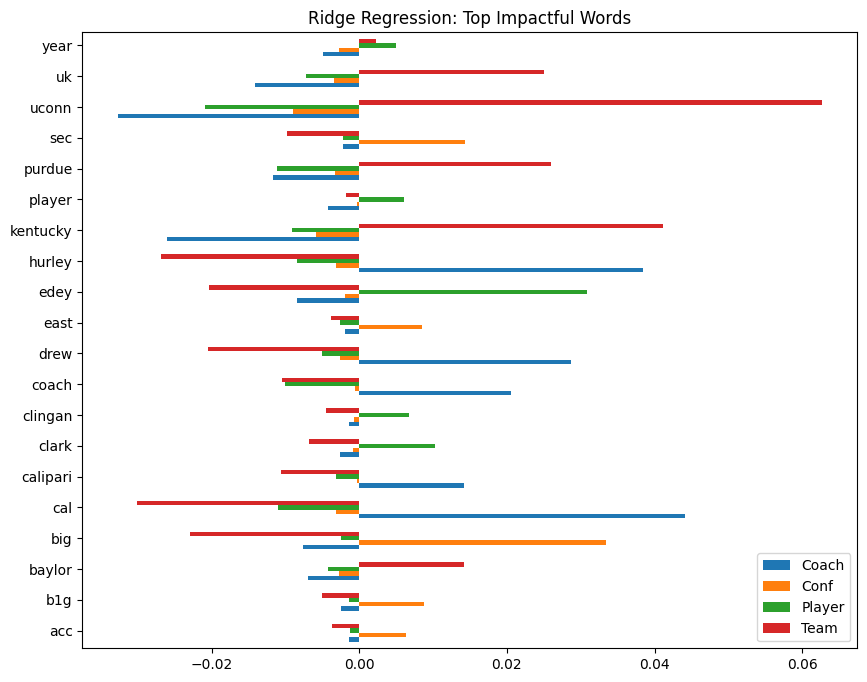

In [ ]:
ax_top,top_terms = plot_impactful_terms(classifier=ridge_clf,x_train=tfidf_train_preds,uniq_labels=cm_cols,vectorizer=tfidf_train_vect,plot_title="Ridge Regression: Top Impactful Words")

In [187]:
y_Eval = prep_test['class']
x_Eval = prep_test['Comments']
final_test_vect, final_test_preds = tdidf_vectorizer(x_Eval,test=True,vect=tfidf_train_vect)

svm_preds = svm.predict(final_test_preds)
mnb_preds = mnb.predict(final_test_preds)
ridge_preds = ridge_clf.predict(final_test_preds)
lr_preds = lr_clf.predict(final_test_preds)

svm_eval_cm = metrics.confusion_matrix(y_Eval,svm_preds,normalize='true')
mnb_eval_cm = metrics.confusion_matrix(y_Eval,mnb_preds,normalize='true')
ridge_eval_cm = metrics.confusion_matrix(y_Eval,ridge_preds,normalize='true')
lr_eval_cm = metrics.confusion_matrix(y_Eval,lr_preds,normalize='true')
test_eval_df = pd.concat([get_metrics(y_Eval,svm_preds),get_metrics(y_Eval,mnb_preds),get_metrics(y_Eval,ridge_preds),get_metrics(y_Eval,lr_preds)])
test_eval_df.index = ['SVM','Multinomial Bayes','Ridge Regression','Logistic Regression']
test_eval_df.head()


Accuracy  Precision  Recall  F1 Score
SVM                      0.76       0.76    0.76      0.75
Multinomial Bayes        0.71       0.74    0.71      0.66
Ridge Regression         0.75       0.75    0.75      0.74
Logistic Regression      0.76       0.76    0.76      0.75

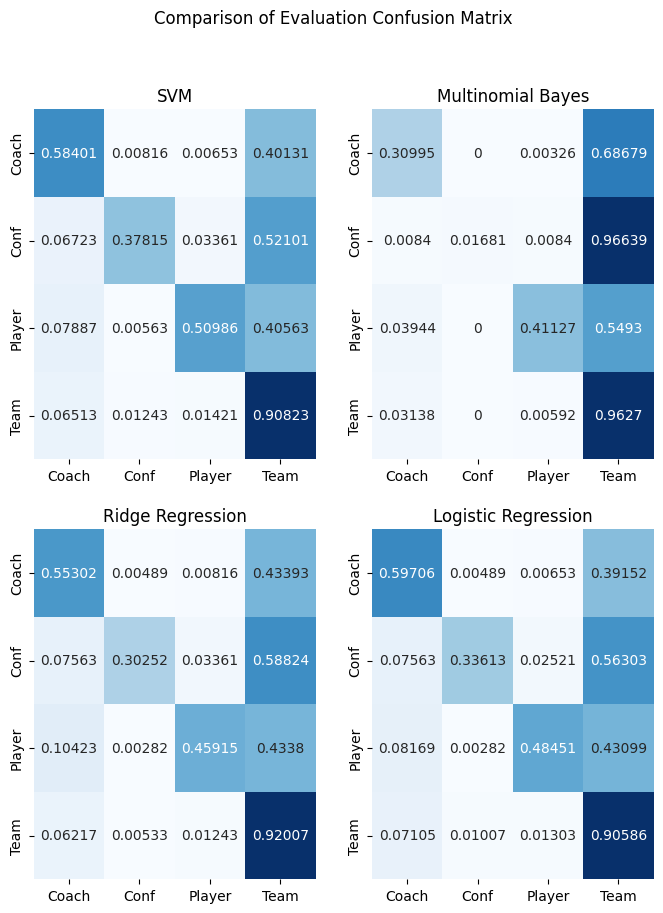

In [188]:

fig, (ax1,ax2) = plt.subplots(2,2,figsize=(8,10))
sns.heatmap(create_cm_df(svm_eval_cm,cols=cm_cols),fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[0]).set_title('SVM')
sns.heatmap(create_cm_df(mnb_eval_cm,cols=cm_cols),fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax1[1]).set_title('Multinomial Bayes')
sns.heatmap(create_cm_df(ridge_eval_cm,cols=cm_cols),fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[0]).set_title('Ridge Regression')
sns.heatmap(create_cm_df(lr_eval_cm,cols=cm_cols),fmt='g',cmap='Blues',annot=True,cbar=False,ax=ax2[1]).set_title('Logistic Regression')
plt.suptitle('Comparison of Evaluation Confusion Matrix')
plt.show();